In [3]:
# Group 6 - Corrine and Jessica
# Complete basic implementation as required by the handout - binary prediction with keras ann
# Can achieve an accuracy of 88% (bigram)
"""
Step 0: Import the necessary dependencies and download NLTK resources
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from contractions import CONTRACTION_MAP

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk import ngrams

from collections import Counter

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

np.random.seed(42)

/Users/yiningxiang/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yiningxiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yiningxiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yiningxiang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/yiningxiang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
"""
Step 1: Load the training data and quick EDA
"""
train_data = pd.read_csv('ReviewsTraining.csv')
test_data = pd.read_csv('ReviewsTest.csv')

# Set the display options for pandas to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 2000)
pd.set_option('display.expand_frame_repr', False)

class DataLoader:
    def __init__(self):
        # Create a set of stopwords
        self.stop_words = set(stopwords.words('english'))
        # Remove negation words from stopwords as they're important for sentiment
        self.negation_words = {'no', 'not', 'nor', 'none', 'never', 'neither', 'hardly', 'barely'}
        self.stop_words = self.stop_words - self.negation_words

    def explore_data(self, data):
        """
        This function explores the data structure and prints the first few rows
        :param data: The input data
        :return: None
        """
        # Check the structure
        print("Data shape:", data.shape)
        print("\nColumns:", data.columns.tolist())
        print("\nSample data:")
        print(data.head())

        # Check for missing values
        print("\nMissing values:")
        print(data.isnull().sum())

    def plot_score_distribution(self, data):
        """
        This function plots the distribution of review scores
        :param data: The input data
        :return: None
        """
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(x='Score', data=data)
        plt.title('Distribution of Review Scores')
        plt.xlabel('Score')
        plt.ylabel('Count')

        # Add count labels on top of bars
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='baseline',
                        xytext=(0, 5), textcoords='offset points')

        plt.tight_layout()
        plt.show()

# # Uncomment the following lines to explore the training data
# # Create an instance of the DataLoader class
# data_loader = DataLoader()
# data_loader.explore_data(train_data) # Explore the training data
# data_loader.plot_score_distribution(train_data) # Plot the distribution of review scores

In [5]:
"""
Step 2: Text Preprocessing
    2.1 Expand contractions
    2.2 Text cleaning to lowercase, remove punctuation, and numbers
    2.3 Tokenization
    2.4 Remove stopwords but keep sentiment words, especially negation words
    2.5 Lemmatization
"""

class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        # Remove negation words from stopwords as they're important for sentiment
        self.negation_words = {'no', 'not', 'nor', 'none', 'never', 'neither', 'hardly', 'barely'}
        self.stop_words = self.stop_words - self.negation_words


    def expand_contractions(self, text, contraction_mapping=CONTRACTION_MAP):
        """
        This function expands contractions in the text
        :param text: The input text
        :param contraction_mapping: The contraction mapping
        :return: The text with expanded contractions

        @example: 'don't' -> 'do not', 'can't' -> 'cannot'
        """
        if isinstance(text, str):
            contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                              flags=re.IGNORECASE | re.DOTALL)

            def expand_match(contraction):
                match = contraction.group(0)
                first_char = match[0]
                expanded_contraction = contraction_mapping.get(match) \
                    if contraction_mapping.get(match) \
                    else contraction_mapping.get(match.lower())
                expanded_contraction = first_char + expanded_contraction[1:] if expanded_contraction else match
                return expanded_contraction

            expanded_text = contractions_pattern.sub(expand_match, text)
            return expanded_text
        else:
            return ""


    def preprocess_text(self, text):
        """
        Apply all preprocessing steps described above
        :param text: Raw text input
        :return: Preprocessed text
        """
        if not isinstance(text, str) or len(text.strip()) == 0:
            return ""

        # Expand contractions
        text = self.expand_contractions(text)
        # Convert to lowercase
        text = text.lower()
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Tokenize
        tokens = word_tokenize(text)
        # Remove stopwords
        tokens = [token for token in tokens if token not in self.stop_words]
        # Lemmatize tokens
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        # Join tokens back into text
        return ' '.join(tokens)


    def preprocess_dataframe(self, df, text_col='Text', summary_col='Summary'):
        """
        Preprocess both text and summary columns and combine them

        :param df: DataFrame containing text data
        :param text_col: Name of the column containing the main text
        :param summary_col: Name of the column containing the summary
        :return: DataFrame with preprocessed text
        """
        df_processed = df.copy()

        df_processed[f'{summary_col}_processed'] = df_processed[summary_col].apply(self.preprocess_text)
        df_processed[f'{text_col}_processed'] = df_processed[text_col].apply(self.preprocess_text)

        # Combine the processed columns
        df_processed['combined_text'] = df_processed[f'{summary_col}_processed'] + ' ' + df_processed[
            f'{text_col}_processed']

        return df_processed

# # Uncomment the following lines to test the TextPreprocessor class
# text_preprocessor = TextPreprocessor()
# example_text = "I can't believe it's not butter!"
# print(f"Original: {example_text}")
# print(f"Preprocessed: {text_preprocessor.preprocess_text(example_text)}")
# print()
# for line in test_data['Text']:
#     print(f"Original: {line}")
#     print(f"Preprocessed: {text_preprocessor.preprocess_text(line)}")
#     print()

text_preprocessor = TextPreprocessor()
train_data_processed = text_preprocessor.preprocess_dataframe(train_data)
test_data_processed = text_preprocessor.preprocess_dataframe(test_data)

# train_data_processed # You can comment this line if you don't want to see the processed data

In [6]:
"""
Step 3: Feature Engineering
    3.1 Convert scores to binary sentiment (1 = positive, 0 = negative)
    3.2 Vectorize text data using TF-IDF
    3.3 Split the data for training and validation
"""
# Convert scores to binary sentiment (scores 1-3 = negative, 4-5 = positive)
train_data_processed['sentiment_binary'] = train_data_processed['Score'].apply(lambda x: 1 if x >= 4 else 0)

# Unigrams only
unigram_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 1))
X_unigram = unigram_vectorizer.fit_transform(train_data_processed['combined_text'])

# Bigrams + Unigrams
bigram_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_bigram = bigram_vectorizer.fit_transform(train_data_processed['combined_text'])


# Split the data for training and validation
X_unigram_train, X_unigram_val, y_train_unigram, y_val_unigram = train_test_split(
    X_unigram, train_data_processed['sentiment_binary'], test_size=0.2, random_state=42
)

X_bigram_train, X_bigram_val, y_train_bigram, y_val_bigram = train_test_split(
    X_bigram, train_data_processed['sentiment_binary'], test_size=0.2, random_state=42
)

In [7]:
"""
Step 4: Model Building and Training
    4.1 Build unigram model
    4.2 Build bigram model
    4.3 Compare model performance
"""
def create_model(input_dim):
    """
    Creates a Keras ANN model for sentiment classification
    """
    model = Sequential([
        Dense(256, input_shape=(input_dim,), activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model


# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train unigram model
print("\nTraining unigram model:")
unigram_model = create_model(X_unigram_train.shape[1])
unigram_model.summary()

history_unigram = unigram_model.fit(
    X_unigram_train, y_train_unigram,
    epochs=10,
    batch_size=64,
    validation_data=(X_unigram_val, y_val_unigram),
    callbacks=[early_stopping],
    verbose=1
)

# Train bigram model
print("\nTraining bigram model:")
bigram_model = create_model(X_bigram_train.shape[1])
bigram_model.summary()

history_bigram = bigram_model.fit(
    X_bigram_train, y_train_bigram,
    epochs=10,
    batch_size=64,
    validation_data=(X_bigram_val, y_val_bigram),
    callbacks=[early_stopping],
    verbose=1
)


Training unigram model:


/Users/yiningxiang/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,473 (5.04 MB)

 Trainable params: 1,321,473 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7334 - loss: 0.5905 - val_accuracy: 0.7750 - val_loss: 0.3968
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8086 - loss: 0.3071 - val_accuracy: 0.8630 - val_loss: 0.3307
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9636 - loss: 0.1272 - val_accuracy: 0.8730 - val_loss: 0.4239
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9867 - loss: 0.0517 - val_accuracy: 0.8620 - val_loss: 0.5370
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0138 - val_accuracy: 0.8640 - val_loss: 0.7301
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.

Training bigram model:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,473 (5.04 MB)

 Trainable params: 1,321,473 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7496 - loss: 0.5885 - val_accuracy: 0.7750 - val_loss: 0.3899
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7940 - loss: 0.3040 - val_accuracy: 0.8800 - val_loss: 0.3352
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9659 - loss: 0.1370 - val_accuracy: 0.8790 - val_loss: 0.4523
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9939 - loss: 0.0322 - val_accuracy: 0.8700 - val_loss: 0.5528
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9967 - loss: 0.0162 - val_accuracy: 0.8710 - val_loss: 0.6540
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Below are the Model performance comparison:
Unigram model accuracy: 0.8630
Bigram model accuracy: 0.8800

bigram model is the best model here.


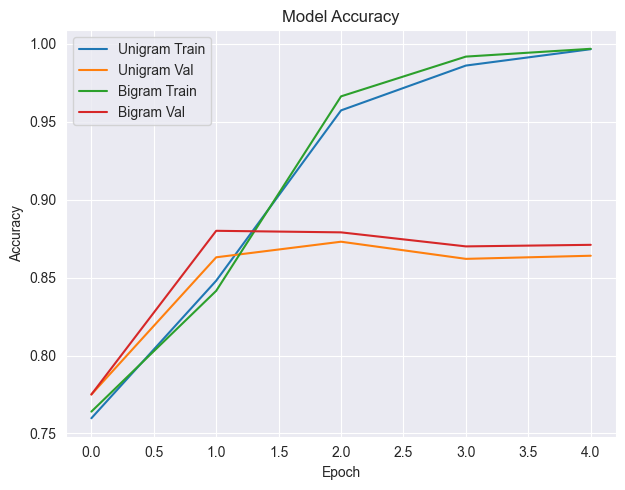

In [8]:
""" 4.3 Evaluate and compare model performance
    You can choose to display the full classification report or just the accuracy.
        - evaluate_model(model, X_val, y_val, model_name)
    method: evaluate_model(model, X_val, y_val, model_name)
    Finally, save the best model and vectorizer for future use.
"""
class ModelEvaluator:
    def __init__(self):
        pass

    def evaluate_model(self, model, X_val, y_val, model_name, plot=False):
        """
        This function evaluates the model on the validation set.
        It also displays the classification report and accuracy of the model
        """
        y_pred_prob = model.predict(X_val)
        y_pred = (y_pred_prob > 0.5).astype(int)

        if y_pred.ndim > 1:
            y_pred = y_pred.flatten()

        accuracy = accuracy_score(y_val, y_pred)

        if plot:
            print(f"\n{model_name} model evaluation:")
            print(f"Accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            print(classification_report(y_val, y_pred))

        return accuracy, y_pred

    def plot_training_history(self, history_unigram, history_bigram, save_path='model_performance.png'):
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(history_unigram.history['accuracy'], label='Unigram Train')
        plt.plot(history_unigram.history['val_accuracy'], label='Unigram Val')
        plt.plot(history_bigram.history['accuracy'], label='Bigram Train')
        plt.plot(history_bigram.history['val_accuracy'], label='Bigram Val')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()

        plt.tight_layout()
        plt.savefig(save_path)
        plt.show()

    def compare_models(self, unigram_accuracy, bigram_accuracy, unigram_model, bigram_model,
                      unigram_vectorizer, bigram_vectorizer):
        """Compare the performance of two models and return the best model"""
        print("\nBelow are the Model performance comparison:")
        print(f"Unigram model accuracy: {unigram_accuracy:.4f}")
        print(f"Bigram model accuracy: {bigram_accuracy:.4f}")

        if bigram_accuracy > unigram_accuracy:
            best_model = bigram_model
            best_vectorizer = bigram_vectorizer
            best_model_name = 'bigram'
        else:
            best_model = unigram_model
            best_vectorizer = unigram_vectorizer
            best_model_name = 'unigram'

        print(f"\n{best_model_name} model is the best model here.")

        return best_model, best_vectorizer, best_model_name

model_evaluator = ModelEvaluator()
# Set plot to True to display full details of the classification report
unigram_accuracy, y_pred_unigram = model_evaluator.evaluate_model(unigram_model, X_unigram_val, y_val_unigram, 'Unigram', plot=False)
bigram_accuracy, y_pred_bigram = model_evaluator.evaluate_model(bigram_model, X_bigram_val, y_val_bigram, 'Bigram', plot=False)
best_model, best_vectorizer, best_model_name = model_evaluator.compare_models(unigram_accuracy, bigram_accuracy, unigram_model, bigram_model,unigram_vectorizer, bigram_vectorizer)
model_evaluator.plot_training_history(history_unigram, history_bigram)



In [9]:
"""
Step 5: Generating Predictions for Test Data
    5.1 Transform test data
    5.2 Generate some predictions and display the prediction summary
    5.3 Save the prediction results to a new file called `Team6predictions.txt`
"""

# Transform test data
X_test = best_vectorizer.transform(test_data_processed['combined_text'])

# Generate predictions
y_pred_proba = best_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Display prediction summary
print("\nTest data prediction summary:")
print(f"Total predictions: {len(y_pred)}")
print(f"Positive sentiment (1): {np.sum(y_pred)} samples ({np.sum(y_pred) / len(y_pred) * 100:.2f}%)")
print(
    f"Negative sentiment (0): {len(y_pred) - np.sum(y_pred)} samples ({(len(y_pred) - np.sum(y_pred)) / len(y_pred) * 100:.2f}%)")

# Save predictions to file
np.savetxt('Team6predictions.txt', y_pred, fmt='%d')
print("\nPredictions saved to 'Team6predictions.txt'")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Test data prediction summary:
Total predictions: 500
Positive sentiment (1): 394 samples (78.80%)
Negative sentiment (0): 106 samples (21.20%)

Predictions saved to 'Team6predictions.txt'


In [10]:
"""
Step 6: Business Insights Analysis
    6.1 Define a reusable function that can get the most frequently used words in positive / negative reviews
    Identify frequent words in negative reviews
    6.2 Find recurring phrases that indicate product issues
    6.3 Provide strategic recommendations
"""
class ReviewAnalyzer:
    def __init__(self, data_df, sentiment_col='sentiment_binary', text_col='combined_text'):
        """
        data_df = train_data_processed / test_data_processed
        """
        self.data = data_df
        self.sentiment_col = sentiment_col
        self.text_col = text_col


    def get_reviews_summary(self):
        sentiment_counts = self.data['sentiment_binary'].value_counts()
        print(f"Positive reviews: {sentiment_counts[1]} ({sentiment_counts[1] / len(self.data) * 100:.2f}%)")
        print(f"Negative reviews: {sentiment_counts[0]} ({sentiment_counts[0] / len(self.data) * 100:.2f}%)")


    def get_pos_neg_reviews(self, positive):
        """This function returns positive / negative reviews based on the input positive"""
        if positive == 1:
            return 'positive', self.data[self.data[self.sentiment_col] == 1][self.text_col]
        elif positive == 0:
            return 'negative', self.data[self.data[self.sentiment_col] == 0][self.text_col]


    def get_unigram_frequent_words(self, reviews, review_type):
        """This function returns the most frequent words in the unigram model"""
        text = ' '.join(reviews)
        words = text.split()
        word_freq = Counter(words)

        print(f"\n1. (Unigram) Most frequent words in {review_type} reviews:")
        for word, count in word_freq.most_common(20):
            if len(word) > 2:
                print(f"   {word}: {count}")


    def get_bigram_frequent_words(self, reviews, review_type):
        """This function returns the most frequent words in the bigram model"""
        bigrams = list(ngrams(' '.join(reviews).split(), 2))
        bigram_freq = Counter(bigrams)

        print(f"\n2. (Bigram) Most common phrases in {review_type} reviews:")
        for bigram, count in bigram_freq.most_common(20):
            print(f"   '{bigram[0]} {bigram[1]}': {count}")


# # Extract important features for negative sentiment
# def get_important_features(vectorizer, model, class_index=0, top_n=20):
#     """
#     Extract features most strongly associated with a particular class
#     """
#     feature_names = vectorizer.get_feature_names_out()
#     weights = model.layers[0].get_weights()[0]
#
#     # For binary classification, use weights for the output neuron
#     if weights.shape[1] == 1:
#         feature_weights = weights.flatten()
#     else:
#         # For multi-class, use weights for the specified class
#         feature_weights = weights[:, class_index]

review_analyzer = ReviewAnalyzer(train_data_processed)
# # Uncomment to see the review summary, including the total number of positive / negative reviews
# review_analyzer.get_reviews_summary()
positive_reviews = review_analyzer.get_pos_neg_reviews(positive=1)
negative_reviews = review_analyzer.get_pos_neg_reviews(positive=0)

pos_uni = review_analyzer.get_unigram_frequent_words(positive_reviews[1], positive_reviews[0])
pos_bi = review_analyzer.get_bigram_frequent_words(positive_reviews[1], positive_reviews[0])

neg_uni = review_analyzer.get_unigram_frequent_words(negative_reviews[1], negative_reviews[0])
neg_bi = review_analyzer.get_bigram_frequent_words(negative_reviews[1], negative_reviews[0])



1. (Unigram) Most frequent words in positive reviews:
   not: 3487
   great: 1969
   good: 1818
   like: 1590
   love: 1399
   taste: 1340
   flavor: 1313
   product: 1199
   one: 1141
   chip: 1127
   coffee: 1046
   food: 1029
   best: 956
   tea: 876
   would: 844
   make: 819
   dog: 755
   bag: 716
   really: 697

2. (Bigram) Most common phrases in positive reviews:
   'dog food': 250
   'gluten free': 206
   'hot chocolate': 160
   'highly recommend': 159
   'potato chip': 158
   'great product': 149
   'not like': 131
   'taste great': 129
   'hot cocoa': 126
   'grocery store': 124
   'green tea': 121
   'taste like': 113
   'could not': 110
   'really good': 110
   'year old': 97
   'taste good': 94
   'much better': 92
   'dog love': 88
   'salt vinegar': 88
   'really like': 85

1. (Unigram) Most frequent words in negative reviews:
   not: 2183
   like: 635
   taste: 598
   product: 520
   would: 462
   flavor: 428
   good: 422
   one: 405
   food: 307
   chip: 302
   coffe

In [11]:
""" 6.3 Business Insights Analysis

Challenges and benefits of using Unigram and Bigram

By using Bigram, adjacent two words (pairs of words) provide more information about given reviews. For example, “not good” is a common negative expression, but observing “not” and “like” separately (using Unigram) is hard for us to distinguish whether customers like or do not like products. However, Bigram often leads to a sparse feature matrix and creates repetitions of words. Also, more features mean an increased risk of overfitting, which will even decrease the model accuracy.

By using Unigram, the procedure is straightforward and simpler compared to Bigram. Memory usage by the Unigram method is less than Bigram. Some phrases may be split into two unrelated words, such as “green tea,” because of the loss of context mentioned before.

We also meet some challenges when using Unigram and Bigram:
- Sarcasm and ironic words are often used in reviews, especially negative reviews. It is difficult to capture that in a large dataset unless we know the relationship or specific content of a sentence.
- Bigram has a higher risk of overfitting, which may lead to a decline in our model’s accuracy. This is an important part we need to pay attention to.

Business Insights
1. What are the most frequent words associated with negative reviews? What are the main
areas of underlying problems that are reflected in these words?
- Unigram method top five frequent words in negative reviews: not, like, taste, product, would
- Bigram method top five frequent words in negative reviews: taste like, not good, would not, not buy, could not
- “Not” or “would not” or “could not”: a common way to express negatively. We keep that to make our results more accurate. If we remove “not” by generally removing the stopwords, it is hard to distinguish “not like” and “like” after cleaning the text, which is important for Bigram. Therefore, we can observe “not good” and “not buy” in the top five frequent words by applying the Bigram method and these suggest fundamental issues of products.
- “Like”: a very common word to express the satisfaction of a product. It frequently appears in negative reviews because some expressions, such as “not like,” would be tokenized to “like” by unigram. Thus, this may also suggest fundamental issues of products
- “Taste” or “Taste like”: for reviews of food, people usually describe the flavour of that food, so they appear frequently in reviews. These are related to sensory issues with food products.
- “Product”: all the reviews are related to products, so it appears very often but is not very useful for giving any sentimental information.

2. Are there recurring phrases that indicate product defects or poor customer service?
- “not good”, “not buy”, “not like”, “not sure”: quality issues
- “taste like”, “not taste”, “taste not”, “flavor not”: taste or flavour issues, maybe quality issues
- “not get”: related to expectations of products or service issues

3. Based on the recurring negative-review patterns, what specific improvements or
strategic changes would you recommend to address these concerns?
- Need to improve quality control processes, which is a very frequently mentioned defect. Improving the quality of products would attract more customers to buy and reduce some negative reviews.
- May try another recipe or try other ingredients to improve the taste. Also, it is important to enhance the taste-testing process and collect ideas from those customers to improve products.
- Make a survey or feedback form for customers to collect information about their expectations for products and try to approach the expectations to keep regular customers and attract more potential customers.
- Improve customer service response times and accessibility and communication with logistics.
"""

' 6.3 Business Insights Analysis\n\nChallenges and benefits of using Unigram and Bigram\n\nBy using Bigram, adjacent two words (pairs of words) provide more information about given reviews. For example, “not good” is a common negative expression, but observing “not” and “like” separately (using Unigram) is hard for us to distinguish whether customers like or do not like products. However, Bigram often leads to a sparse feature matrix and creates repetitions of words. Also, more features mean an increased risk of overfitting, which will even decrease the model accuracy.\n\nBy using Unigram, the procedure is straightforward and simpler compared to Bigram. Memory usage by the Unigram method is less than Bigram. Some phrases may be split into two unrelated words, such as “green tea,” because of the loss of context mentioned before.\n\nWe also meet some challenges when using Unigram and Bigram:\n- Sarcasm and ironic words are often used in reviews, especially negative reviews. It is difficu